In [1]:
%config Completer.use_jedi = False

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import folium
import json

# Exploretory Data Analysis

In [3]:
df = pd.read_csv('vancouver_yelp_restaurants.csv')

# Enthält keine Werte
df.drop(columns="Open24Hours", inplace=True)
df.drop(columns="is_open", inplace=True)

# Nur Restaurants in British Columbia, Kanada (BC)
df = df[df["state"].str.lower() == "bc"]

# Wie viele Kategorien werden angegeben
df['categories_len'] = df["categories"].apply(lambda x: len(x.split(',')))

# Besseren Name für Price Range
df.rename(columns={'RestaurantsPriceRange2':'price_range'}, inplace=True)

# Füllen der NaN Werte + ein String None
df['price_range'] = df['price_range'].fillna(0).replace("None", 0)
df['price_range'] = df['price_range'].astype('int64')

# Fixen von Inkonsistenz der Klassen und füllen der NaNs (bsp: u'loud', 'loud', entfernen vom 'u')
df['NoiseLevel'] = df['NoiseLevel'].fillna("'unkown'").replace("None", "'unkown'")
df['Alcohol'] = df['Alcohol'].fillna("'none'").replace("None", "'none'")
df['WiFi'] = df['WiFi'].fillna("'no'").replace("None", "'no'")
df['RestaurantsAttire'] = df['RestaurantsAttire'].fillna("'unkown'").replace("None", "'unkown'")
df['RestaurantsReservations'] = df['RestaurantsReservations'].fillna("False").replace("None", "False")
df['Caters'] = df['RestaurantsReservations'].fillna("False").replace("None", "False")
df['HasTV'] = df['HasTV'].fillna("False").replace("None", "False")
for x in ['NoiseLevel', 'Alcohol', 'WiFi', 'RestaurantsAttire']:
    df[x] = df[x].apply(lambda x: x[1:] if x[0] == 'u' else x[:])

Weiter gefasste Postleitzahlen in eigene Zeile

In [4]:
df["broad_postal_code"] = df["postal_code"].apply(lambda x: str(x)[:3])

Hilfsmethoden um einzufügen wie lange ein Geschäft offen ist

In [5]:
# Errechnet wie lange ein Laden am Tag offen ist
def time_open(opened, closed):
    # Wenn opened kleiner als 0 ist war es nicht angegeben NaN
    if (opened < 0):
        return -1
    # Wenn opened größer oder gleich ist (z.B 0:00-0:00 oder 17:00-1:00) dann + 24
    return closed - opened if opened < closed else closed + 24 - opened

# Errechnet die durschnittliche Öffnungzeit
# open_hours: Liste mit öffenen Stunden
def average_open(open_hours):
    x = 0
    for hours in open_hours:
        x += hours if hours > -1 else 0
    return x / len(open_hours)

In [6]:
for x in ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]:
    # Ersetzen der Bindestriche - in + damit wir das Minuszeichen weiter benutzen können 
    df[x] = df[x].str.replace("-", "+")
    # NaN durch Minuszahlen ersetzen für spätere Abfrage
    df[x].fillna("-1:0+-1:0", inplace=True)

for x in ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]:
    opened = df[x].apply(lambda x: re.split(":|\+", x)[0]).astype("int64")
    closed = df[x].apply(lambda x: re.split(":|\+", x)[2]).astype("int64")
    temp_df = pd.concat([opened.rename("opened"), closed.rename("closed")], axis=1)
    df[x.lower() + "_hours"] = temp_df.apply(lambda x: time_open(x.opened, x.closed), axis=1)
    
# Wochentage und Wochenende den Druchschnitt bilden
df["weekday_hours"] = df.apply(lambda x: average_open([x.monday_hours, x.tuesday_hours, x.wednesday_hours, x.thursday_hours,
                                                        x.friday_hours]), axis=1)
df["weekend_hours"] = df.apply(lambda x: average_open([x.saturday_hours, x.sunday_hours]), axis=1)

In [7]:
# Interessante Zeilen nur
df = df[['business_id','name','address','city','state','postal_code','broad_postal_code','latitude','longitude','stars_fair',
         'stars','review_count','attributes','categories','hours','Alcohol','RestaurantsReservations','RestaurantsAttire',
         'price_range','HasTV','NoiseLevel','WiFi','Caters','Ambience','DietaryRestrictions','Monday','Tuesday','Wednesday',
         'Thursday','Friday','Saturday','Sunday','categories_len','monday_hours','tuesday_hours','wednesday_hours',
         'thursday_hours','friday_hours','saturday_hours','sunday_hours','weekday_hours','weekend_hours']]

#### Extra boolean Spalten für die Kategorien erstellen 

In [8]:
categories = ['Japanese', 'Sandwiches', 'Nightlife','Bars', 'Coffee & Tea', 'Chinese', 'Breakfast & Brunch',
              'Canadian', 'Italian', 'Fast Food', 'Seafood', 'Burgers', 'Vietnamese', 'Bakeries', 'American',
              'Asian Fusion', 'Vegetarian', 'Indian', 'Mexican', 'Middle Eastern', 'Vegan', 'Mediterranean', 'Thai',
              'Korean', 'Gluten-Free', 'Delis', 'French', 'Barbeque', 'Taiwanese', 'Greek','Steakhouses', 'Latin American',
              'Pakistani', 'Bubble Tea']

In [9]:
categories_search = ['Japanese|Sushi Bars|Ramen', 'Sandwiches', 'Nightlife','Bars', 'Coffee & Tea|Coffee \& Tea|Cafes', 'Chinese|Dim Sum', 
             'Breakfast & Brunch', 'Canadian', 'Italian|Pizza', 'Fast Food', 'Seafood', 'Burgers', 'Vietnamese', 
             'Bakeries', 'American|American \(New\)|American \(Traditional\)', 'Asian Fusion', 'Vegetarian', 'Indian', 'Mexican', 
              'Middle Eastern', 'Vegan', 'Mediterranean', 'Thai', 'Korean', 'Gluten-Free', 'Delis', 'French', 'Barbeque', 
              'Taiwanese', 'Greek','Steakhouses', 'Latin American', 'Pakistani', 'Bubble Tea']

for cat in categories_search:
    cat_name = cat.split("|")
    df[cat_name[0]] = df['categories'].apply(lambda x: True if re.search(cat, x) else False)

In [10]:
df.head()

,business_id,name,address,city,state,postal_code,broad_postal_code,latitude,longitude,stars_fair,...,Gluten-Free,Delis,French,Barbeque,Taiwanese,Greek,Steakhouses,Latin American,Pakistani,Bubble Tea
0,D4JtQNTI4X3KcbzacDJsMw,Bob Likes Thai Food,3755 Main St,Vancouver,BC,V5V,V5V,49.251342,-123.101333,3.485632,...,False,False,False,False,False,False,False,False,False,False
2,jfDfHzAq6iKkRnzzZ4n1nQ,Let's Roll Custom Sushi Bar,"1184 Denman Street, Suite 104",Vancouver,BC,V6G 2M9,V6G,49.286360,-123.140261,4.291667,...,False,False,False,False,False,False,False,False,False,False
4,OfA_4cHgvlknHMcn0qNs2w,Little Caesars,7010 Kerr Street,Vancouver,BC,V5S,V5S,49.219532,-123.040893,1.714286,...,False,False,False,False,False,False,False,False,False,False
5,7ee6XyKyeduI-Rbc6L5j2Q,NingTu Restaurant,2130 Kingsway,Vancouver,BC,V5N 2T5,V5N,49.244079,-123.063337,3.923077,...,False,False,False,False,False,False,False,False,False,False
6,r-hWf-bd9im5rj_l2MeofQ,Take Five Café,102-609 Granville Street,Vancouver,BC,V7Y 1H4,V7Y,49.283532,-123.117107,3.772727,...,False,False,False,False,False,False,False,False,False,False


In [11]:
df.describe()

,latitude,longitude,stars_fair,stars,review_count,price_range,categories_len,monday_hours,tuesday_hours,wednesday_hours,thursday_hours,friday_hours,saturday_hours,sunday_hours,weekday_hours,weekend_hours
count,4277.000000,4277.000000,4277.000000,4277.000000,4277.000000,4277.000000,4277.000000,4277.000000,4277.000000,4277.000000,4277.000000,4277.000000,4277.000000,4277.000000,4277.000000,4277.000000
mean,49.267385,-123.116757,3.434624,3.510755,69.228197,1.527940,4.369418,8.792845,7.766659,8.141454,8.233575,8.535188,8.064999,6.789338,8.492354,7.681903
std,0.019431,0.038054,0.535762,0.663953,115.464306,0.817819,2.200026,7.415102,5.676728,5.446170,5.403539,5.517723,5.760498,6.029767,5.167345,5.375025
min,49.194305,-123.261752,1.312500,1.000000,5.000000,0.000000,1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.000000,0.000000
25%,49.260897,-123.134645,3.000000,3.000000,14.000000,1.000000,3.000000,-1.000000,4.000000,5.000000,5.000000,5.000000,5.000000,-1.000000,5.000000,3.500000
50%,49.271543,-123.118398,3.458333,3.500000,33.000000,2.000000,4.000000,10.000000,9.000000,9.000000,9.000000,10.000000,9.000000,8.000000,9.600000,8.500000
75%,49.281745,-123.100757,3.888889,4.000000,76.000000,2.000000,6.000000,12.000000,11.000000,12.000000,12.000000,12.000000,12.000000,11.000000,12.000000,11.500000
max,49.351517,-123.022436,4.949749,5.000000,2302.000000,4.000000,16.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000


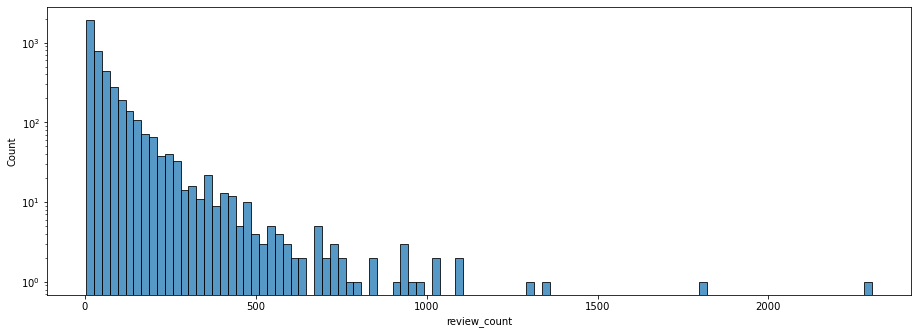

In [12]:
fig = plt.figure()
log_ax = fig.add_axes((0, 0, 2, 1))
log_ax.set_yscale("log")
sns.histplot(data=df, x="review_count", ax=log_ax, bins=100)

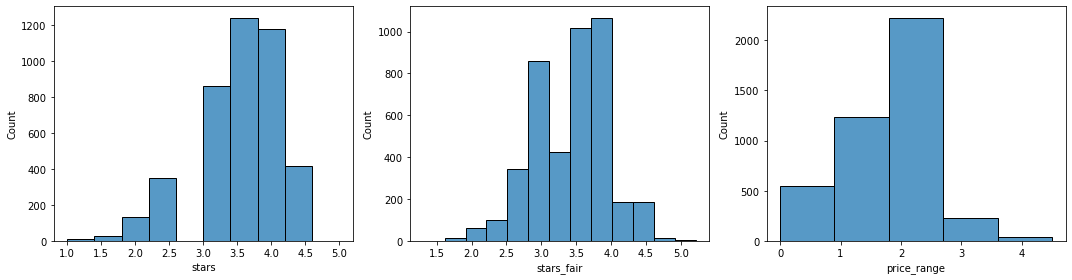

In [13]:
f, axes = plt.subplots(1, 3, figsize=(15,4))
sns.histplot(data=df, x="stars", binwidth=0.4, ax=axes[0])
sns.histplot(data=df, x="stars_fair", binwidth=0.3, ax=axes[1])
sns.histplot(data=df, x="price_range", binwidth=0.9, ax=axes[2])
f.tight_layout()

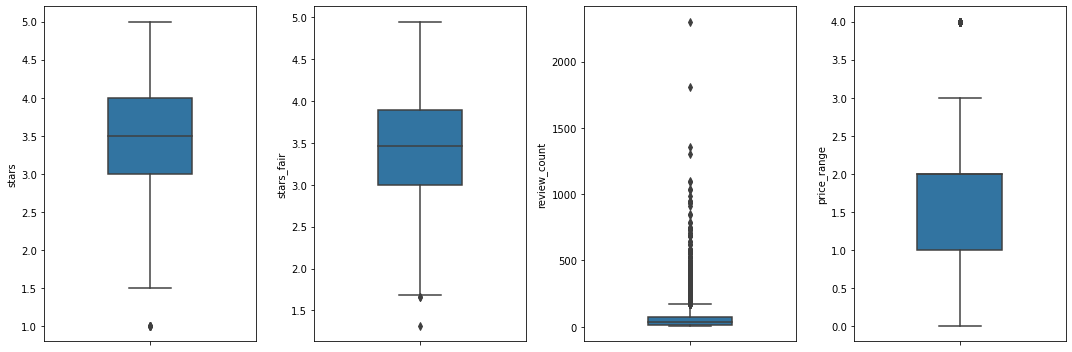

In [14]:
f, axes = plt.subplots(1, 4, figsize=(15,5))
sns.boxplot(data=df, y="stars", width=0.4, ax=axes[0])
sns.boxplot(data=df, y="stars_fair", width=0.4, ax=axes[1])
sns.boxplot(data=df, y="review_count", width=0.4, ax=axes[2])
sns.boxplot(data=df, y="price_range", width=0.4, ax=axes[3])
f.tight_layout()

In [15]:
df[["stars", "price_range", "review_count",'latitude', 'longitude', 'categories_len', 'weekend_hours', 'weekday_hours']].corr()

,stars,price_range,review_count,latitude,longitude,categories_len,weekend_hours,weekday_hours
stars,1.000000,-0.019719,0.165548,0.056859,0.046291,0.126722,-0.104726,-0.055176
price_range,-0.019719,1.000000,0.260640,0.042826,-0.051779,0.088758,0.039170,-0.000738
review_count,0.165548,0.260640,1.000000,0.117517,0.015277,0.152373,0.147078,0.136226
latitude,0.056859,0.042826,0.117517,1.000000,-0.165024,0.089855,-0.025789,0.018566
longitude,0.046291,-0.051779,0.015277,-0.165024,1.000000,-0.037696,0.045092,0.007131
categories_len,0.126722,0.088758,0.152373,0.089855,-0.037696,1.000000,0.164969,0.219595
weekend_hours,-0.104726,0.039170,0.147078,-0.025789,0.045092,0.164969,1.000000,0.873918
weekday_hours,-0.055176,-0.000738,0.136226,0.018566,0.007131,0.219595,0.873918,1.000000


<AxesSubplot:>

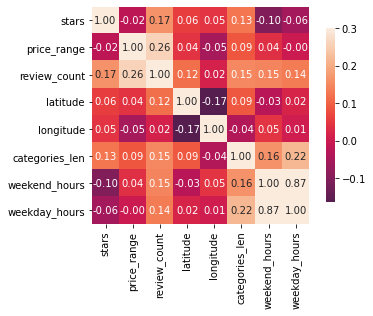

In [16]:
cmap = sns.color_palette("rocket", as_cmap=True)
sns.heatmap(df[["stars", "price_range", "review_count",'latitude', 'longitude', 'categories_len', 'weekend_hours', 'weekday_hours']].corr(), vmax=.3, center=0,
            cmap=cmap, square=True, cbar_kws={"shrink": 0.8}, annot=True, fmt=".2f")

Correlation between weekday and weekend opening hours (giving the stores are open within the week and on weekends)

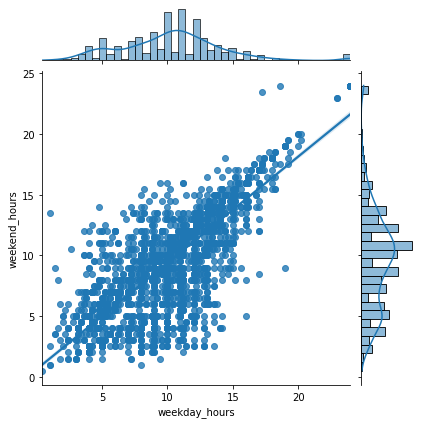

In [17]:
# ignoring missing 0 values
sns.jointplot(data=df[(df['weekday_hours'] != 0) & (df['weekend_hours'] != 0)], x='weekday_hours', y='weekend_hours', kind='reg')

In [18]:
df_category = df[['RestaurantsAttire', 'Alcohol', 'NoiseLevel', 'RestaurantsReservations', 'WiFi', 'HasTV', 'Caters']]

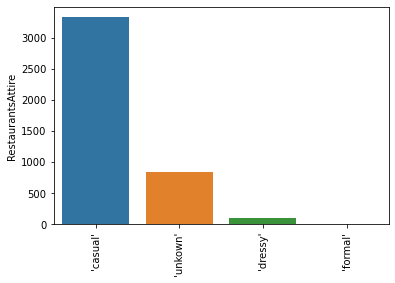

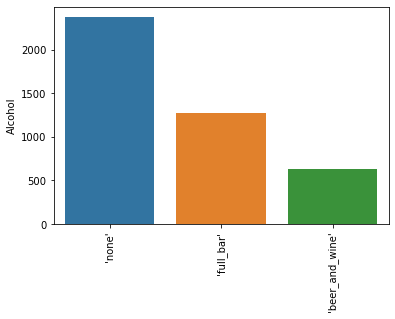

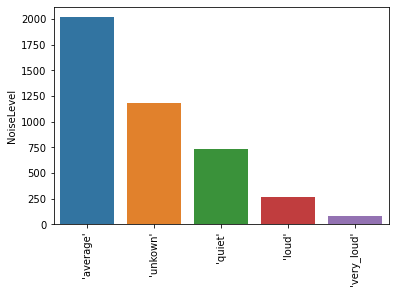

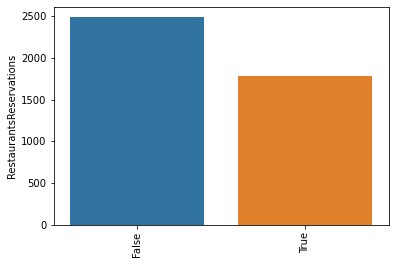

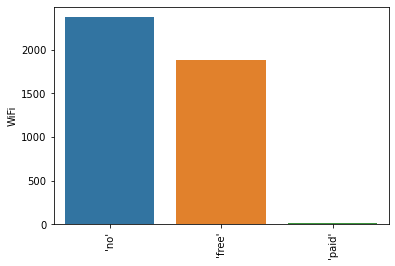

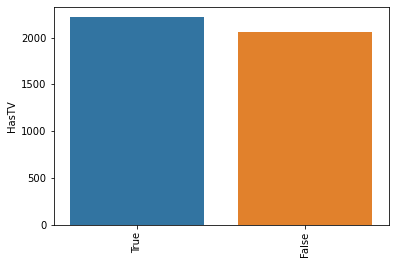

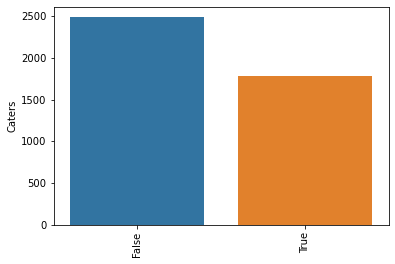

In [19]:
for i in df_category.columns:
    values = df_category[i].value_counts()
    chart = sns.barplot(x=values.index, y=values)
    chart.set_xticklabels(chart.get_xticklabels(), rotation=90)
    plt.show()

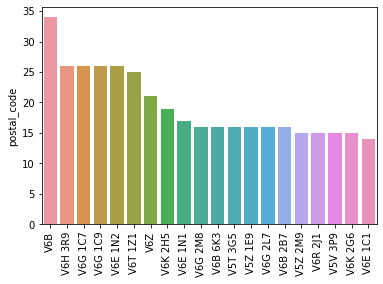

In [20]:
for i in ['postal_code']:
    values = df[i].value_counts()[:20]
    chart = sns.barplot(x=values.index, y=values)
    chart.set_xticklabels(chart.get_xticklabels(), rotation=90)
    plt.show()

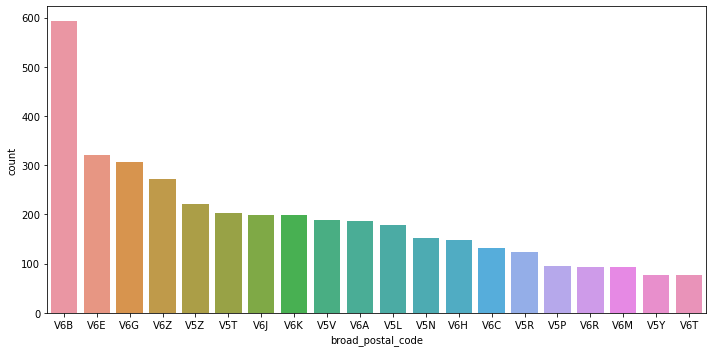

In [21]:
fig = plt.figure(figsize=(10, 5))
temp = df.groupby("broad_postal_code")["postal_code"].describe()
temp = temp.sort_values(['count'], ascending=False).reset_index()[:20]
sns.barplot(data=temp, x="broad_postal_code", y="count")
fig.tight_layout()

## Look at Relations

<AxesSubplot:xlabel='stars'>

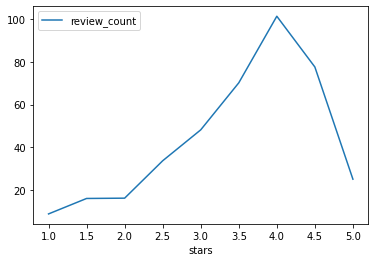

In [22]:
temp = pd.pivot_table(df, index = 'stars', values = 'review_count')
sns.lineplot(data=temp)

<AxesSubplot:xlabel='price_range'>

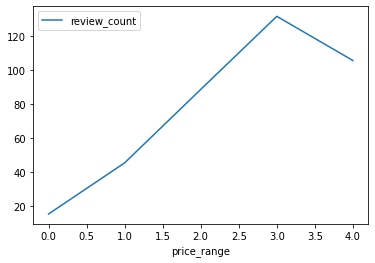

In [23]:
temp = pd.pivot_table(df, index = 'price_range', values = 'review_count')
sns.lineplot(data=temp)

There exist __no__ 1.0-1.5 star restaurant with a 3-4 price range in Vancouver

Also the is no 5 star restaurant with a 3 price range. This is likely do to the fact that restaurants with a price range of 3 get a lot of reviews with makes it hard to keep the perfect record of 5. 

In [24]:
piv_3 = pd.pivot_table(df, index = ['stars', 'price_range'], values = 'review_count')
piv_3 = piv_3.reset_index().pivot(index="stars", columns="price_range", values="review_count")
piv_3

price_range,0,1,2,3,4
stars,,,,,
1.0,5.800000,9.000000,16.500000,NaN,NaN
1.5,10.666667,15.454545,28.166667,NaN,NaN
2.0,7.740741,16.844828,19.904762,23.600000,20.000000
2.5,10.096774,25.857143,45.576687,29.666667,21.600000
3.0,15.527778,34.148305,58.783626,58.388889,14.500000
3.5,15.779661,41.408955,87.902718,110.658228,122.555556
4.0,18.903704,70.553191,125.431562,167.837500,174.923077
4.5,16.220183,50.146789,111.319527,279.842105,94.750000
5.0,12.702703,48.611111,30.700000,NaN,6.000000


<AxesSubplot:xlabel='stars'>

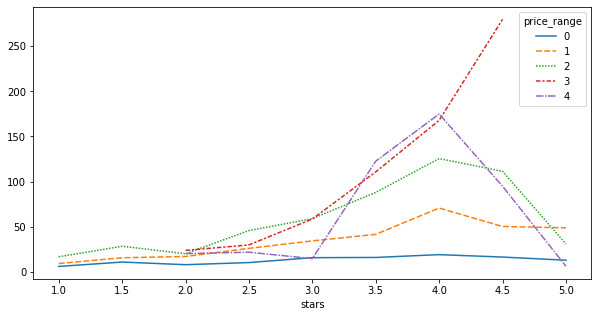

In [25]:
fig = plt.figure(figsize=(10,5))
sns.lineplot(data=piv_3)

In [26]:
pd.pivot_table(df, index = 'Alcohol', values = 'review_count')

,review_count
Alcohol,
'beer_and_wine',89.115689
'full_bar',113.416667
'none',40.265796


In [27]:
pd.pivot_table(df, index = 'Alcohol', values = 'stars')

,stars
Alcohol,
'beer_and_wine',3.469097
'full_bar',3.505503
'none',3.524642


In [28]:
most_postal = df['postal_code'].value_counts()[:20].index.tolist()
pd.pivot_table(df[(df["postal_code"].isin(most_postal))], index = 'postal_code', values = 'stars').sort_values("stars", ascending=False)

,stars
postal_code,
V6G 1C7,3.961538
V5T 3G5,3.812500
V6K 2H5,3.736842
V6G 2L7,3.718750
V6G 1C9,3.692308
V6R 2J1,3.666667
V6K 2G6,3.633333
V6E 1N1,3.588235
V6B 6K3,3.562500


In [29]:
pd.pivot_table(df[(df["postal_code"].isin(most_postal)) & (df['price_range'] != 0)], index = 'postal_code', values = 'price_range').sort_values("price_range", ascending=False)

,price_range
postal_code,
V6B 6K3,2.153846
V5V 3P9,1.866667
V6K 2G6,1.846154
V6G 1C9,1.750000
V6E 1N2,1.739130
V5T 3G5,1.714286
V6G 2L7,1.700000
V6B,1.696970
V6E 1C1,1.692308


In [30]:
df_pivots = df[['RestaurantsAttire', 'Alcohol', 'NoiseLevel', 'RestaurantsReservations', 'WiFi', 'HasTV', 'Caters', "stars_fair", "review_count"]]
for i in ['RestaurantsAttire', 'Alcohol', 'NoiseLevel', 'RestaurantsReservations', 'WiFi', 'HasTV', 'Caters']:
    print("\n\n" + str(i))
    print(pd.pivot_table(df_pivots, index=i, values=["stars_fair", "review_count"]).sort_values("stars_fair", ascending=False))



RestaurantsAttire
                   review_count  stars_fair
RestaurantsAttire                          
'dressy'             117.303922    3.610109
'unkown'              25.817102    3.496131
'casual'              78.779880    3.413880
'formal'              16.333333    3.231061


Alcohol
                 review_count  stars_fair
Alcohol                                  
'full_bar'         113.416667    3.452012
'none'              40.265796    3.429543
'beer_and_wine'     89.115689    3.418688


NoiseLevel
             review_count  stars_fair
NoiseLevel                           
'average'      105.557044    3.462576
'quiet'         38.129781    3.458029
'unkown'        20.530906    3.424798
'loud'          98.996283    3.307896
'very_loud'     56.936709    3.082849


RestaurantsReservations
                         review_count  stars_fair
RestaurantsReservations                          
True                        90.689385    3.447279
False                       53.781665    

In [31]:
print(pd.pivot_table(df, index='stars', values=categories).sort_values("stars", ascending=False))

       American  Asian Fusion  Bakeries  Barbeque      Bars  \
stars                                                         
5.0    0.075758      0.015152  0.090909  0.000000  0.242424   
4.5    0.057971      0.031401  0.084541  0.019324  0.195652   
4.0    0.067063      0.044143  0.061969  0.016129  0.226655   
3.5    0.108065      0.045968  0.041129  0.022581  0.253226   
3.0    0.132404      0.036005  0.020906  0.018583  0.248548   
2.5    0.068966      0.040230  0.037356  0.020115  0.172414   
2.0    0.045113      0.060150  0.082707  0.000000  0.142857   
1.5    0.000000      0.034483  0.000000  0.000000  0.034483   
1.0    0.125000      0.000000  0.000000  0.000000  0.125000   

       Breakfast & Brunch  Bubble Tea   Burgers  Canadian   Chinese  ...  \
stars                                                                ...   
5.0              0.060606    0.060606  0.015152  0.045455  0.000000  ...   
4.5              0.101449    0.014493  0.038647  0.048309  0.053140  ...   
4.

In [32]:
for i in categories:
    print("\n\n" + str(i))
    print(pd.pivot_table(df, index=i, values='review_count'))



Japanese
          review_count
Japanese              
False        66.311002
True         86.933884


Sandwiches
            review_count
Sandwiches              
False          71.177495
True           51.743590


Nightlife
           review_count
Nightlife              
False         63.074242
True         113.788054


Bars
       review_count
Bars               
False     61.452482
True      95.632066


Coffee & Tea
              review_count
Coffee & Tea              
False            71.276957
True             58.540698


Chinese
         review_count
Chinese              
False       71.174714
True        51.585882


Breakfast & Brunch
                    review_count
Breakfast & Brunch              
False                  65.743802
True                  102.540741


Canadian
          review_count
Canadian              
False        65.372075
True        113.176812


Italian
         review_count
Italian              
False       69.821083
True        64.235683


Fast Food
  

In [33]:
for i in categories:
    print("\n\n" + str(i))
    print(pd.pivot_table(df, index='stars', values=i).sort_values(i, ascending=False))



Japanese
       Japanese
stars          
2.0    0.157895
3.5    0.152419
4.0    0.141766
2.5    0.140805
3.0    0.139373
1.0    0.125000
4.5    0.123188
1.5    0.103448
5.0    0.060606


Sandwiches
       Sandwiches
stars            
1.0      0.250000
1.5      0.206897
2.0      0.165414
4.5      0.144928
4.0      0.106112
5.0      0.090909
2.5      0.089080
3.5      0.084677
3.0      0.083624


Nightlife
       Nightlife
stars           
3.5     0.142742
3.0     0.137050
4.0     0.123939
2.5     0.091954
4.5     0.089372
5.0     0.075758
2.0     0.030075
1.0     0.000000
1.5     0.000000


Bars
           Bars
stars          
3.5    0.253226
3.0    0.248548
5.0    0.242424
4.0    0.226655
4.5    0.195652
2.5    0.172414
2.0    0.142857
1.0    0.125000
1.5    0.034483


Coffee & Tea
       Coffee & Tea
stars              
5.0        0.409091
4.5        0.272947
1.0        0.250000
2.0        0.195489
4.0        0.173175
3.5        0.141935
2.5        0.129310
3.0        0.106852
1.5  

In [34]:
pd.pivot_table(df, index="Fast Food", values=['stars', 'review_count', 'stars_fair']).sort_values('stars', ascending=False)

,review_count,stars,stars_fair
Fast Food,,,
False,71.085470,3.547009,3.462779
True,44.518395,3.028428,3.060036


# Karte

In [35]:
value_counts = df['broad_postal_code'].value_counts().reset_index()
value_counts.columns = ['broad_postal_code', 'counts']
table = pd.pivot_table(df, index="broad_postal_code", values=['stars', 'review_count', 'stars_fair', 'price_range']).reset_index()
table = table.merge(value_counts) #.sort_values("counts", ascending=False)
table.drop([44],inplace=True)
table["broad_postal_code"] = table["broad_postal_code"].astype(str)
table.rename(columns={'broad_postal_code': 'postal_code'}, inplace=True)
#table = table[table["counts"] > 4].sort_values("counts", ascending=False).reset_index(drop=True)

In [36]:
vanc_map = folium.Map(location=[49.260428, -123.11509], zoom_start=12, min_zoom=11)
#folium.GeoJson('postal_code_area.json', name="Postal Codes", tooltip=['postal_code']).add_to(vanc_map)
state_data = table
state_geo = r'postal_code_area.json'

choro = folium.Choropleth(geo_data=state_geo,
                  data=state_data,
                  columns=['postal_code','counts'],
                  key_on='feature.properties.postal_code',
                  name="Number of Restaurants",
                  fill_color="RdPu",
                  fill_opacity=0.7,
                  line_opacity=0.5,
                  legend_name='Number of Restaurants'
                  ).add_to(vanc_map)

style_function = "font-size: 15px; font-weight: bold"
choro.geojson.add_child(
    folium.features.GeoJsonTooltip(['postal_code'], style=style_function, labels=False))

folium.LayerControl().add_to(vanc_map)

vanc_map

In [37]:
vanc_map = folium.Map(location=[49.260428, -123.11509], zoom_start=12, min_zoom=11)
#folium.GeoJson('postal_code_area.json', name="Postal Codes", tooltip=['postal_code']).add_to(vanc_map)
state_data = table
state_geo = r'postal_code_area.json'

choro = folium.Choropleth(geo_data=state_geo,
                  data=state_data,
                  columns=['postal_code','review_count'],
                  key_on='feature.properties.postal_code',
                  name="Mean of Reviews Count",
                  fill_color="RdPu",
                  fill_opacity=0.7,
                  line_opacity=0.5,
                  legend_name='Mean of Reviews Count'
                  ).add_to(vanc_map)

style_function = "font-size: 15px; font-weight: bold"
choro.geojson.add_child(
    folium.features.GeoJsonTooltip(['postal_code'], style=style_function, labels=False))

folium.LayerControl().add_to(vanc_map)

vanc_map

In [38]:
vanc_map = folium.Map(location=[49.260428, -123.11509], zoom_start=12, min_zoom=11)

state_data = table
state_geo = r'postal_code_area.json'

choro = folium.Choropleth(geo_data=state_geo,
                  data=state_data,
                  columns=['postal_code','stars'],
                  key_on='feature.properties.postal_code',
                  name="Mean of Stars",
                  fill_color="RdPu",
                  fill_opacity=0.7,
                  line_opacity=0.5,
                  legend_name='Mean of Stars'
                  ).add_to(vanc_map)

style_function = "font-size: 15px; font-weight: bold"
choro.geojson.add_child(
    folium.features.GeoJsonTooltip(['postal_code'], style=style_function, labels=False))
folium.LayerControl().add_to(vanc_map)

vanc_map

In [39]:
vanc_map = folium.Map(location=[49.260428, -123.11509], zoom_start=12, min_zoom=11)

state_data = table
state_geo = r'postal_code_area.json'

choro = folium.Choropleth(geo_data=state_geo,
                  data=state_data,
                  columns=['postal_code','stars_fair'],
                  key_on='feature.properties.postal_code',
                  name="Mean of fair Stars",
                  fill_color="RdPu",
                  fill_opacity=0.7,
                  line_opacity=0.5,
                  legend_name='Mean of fair Stars'
                  ).add_to(vanc_map)

style_function = "font-size: 15px; font-weight: bold"
choro.geojson.add_child(
    folium.features.GeoJsonTooltip(['postal_code'], style=style_function, labels=False))
folium.LayerControl().add_to(vanc_map)

vanc_map

In [40]:
vanc_map = folium.Map(location=[49.260428, -123.11509], zoom_start=12, min_zoom=11)

state_data = table
state_geo = r'postal_code_area.json'

choro = folium.Choropleth(geo_data=state_geo,
                  data=state_data,
                  columns=['postal_code','price_range'],
                  key_on='feature.properties.postal_code',
                  name="Price Range",
                  fill_color="RdPu",
                  fill_opacity=0.7,
                  line_opacity=0.5,
                  legend_name='Price Range'
                  ).add_to(vanc_map)

style_function = "font-size: 15px; font-weight: bold"
choro.geojson.add_child(
    folium.features.GeoJsonTooltip(['postal_code'], style=style_function, labels=False))
folium.LayerControl().add_to(vanc_map)

vanc_map

In [41]:
population_df = pd.read_csv(r"https://raw.githubusercontent.com/BadeJoey/Web_Scraping_Side_Project/main/population_data_vancouver_clean.csv", index_col=0)

In [42]:
population_df.head()

,area_of_postal_code,population,male_population,female_population,median_age,male_median_age,female_median_age,postal_code,male_population_percentage,female_population_percentage
0,3.485,18404,8999,9405,39.7,39.1,40.2,V5L,48.9,51.1
1,4.901,25017,12233,12784,39.7,39.1,40.2,V5M,48.9,51.1
2,4.973,34638,16937,17701,39.7,39.1,40.2,V5N,48.9,51.1
3,5.200,34003,16627,17376,39.7,39.1,40.2,V5P,48.9,51.1
4,5.900,45955,22471,23484,39.7,39.1,40.2,V5R,48.9,51.1


<AxesSubplot:>

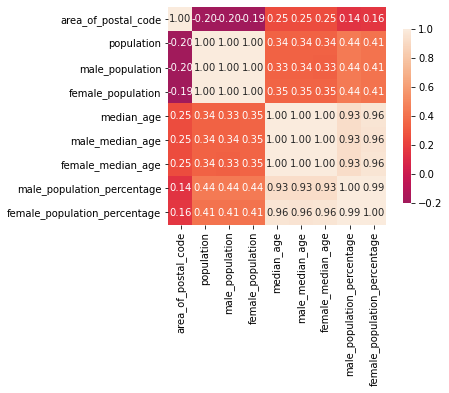

In [43]:
# cmap already defined
sns.heatmap(population_df.corr(), vmax=1, center=0,
            cmap=cmap, square=True, cbar_kws={"shrink": 0.8}, annot=True, fmt=".2f")

In [44]:
df_group = df.groupby("broad_postal_code").mean()

df_population = population_df.set_index("postal_code")

df_combined = df_group.join(df_population, how="inner")

<AxesSubplot:>

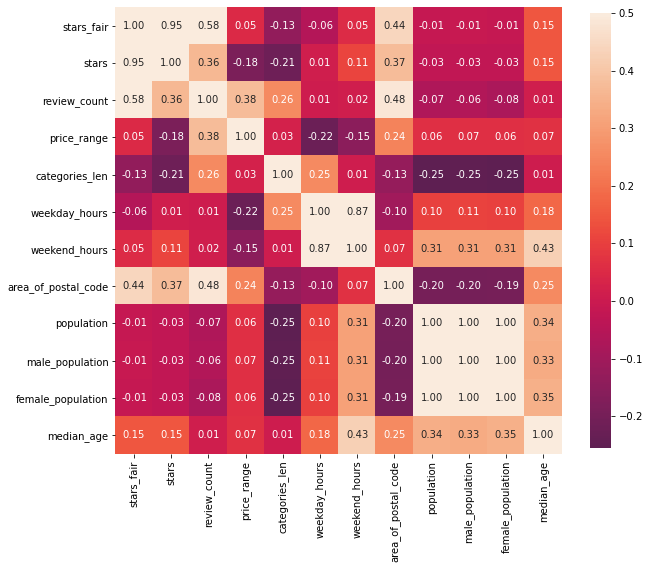

In [45]:
view = df_combined[['stars_fair', 'stars', 'review_count', 'price_range', 'categories_len', 'weekday_hours','weekend_hours', 
                   'area_of_postal_code', 'population','male_population', 'female_population', 'median_age']]
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(view.corr(), vmax=0.5, center=0,
            cmap=cmap, square=True, cbar_kws={"shrink": 0.8}, annot=True, fmt=".2f", ax=ax)

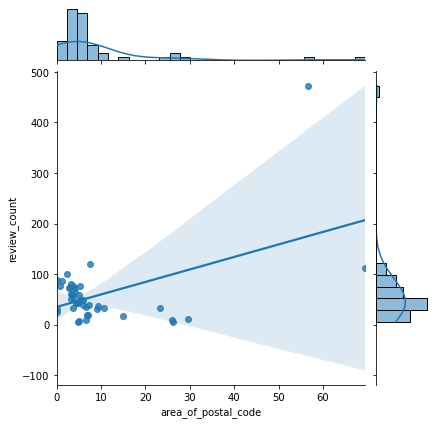

In [46]:
sns.jointplot(data=df_combined, x='area_of_postal_code', y='review_count', kind='reg')

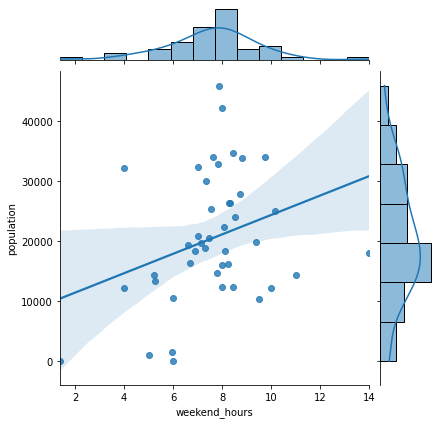

In [47]:
sns.jointplot(data=df_combined, x='weekend_hours', y='population', kind='reg')

### To-Do
- ~Zusammenhang zwischen 5 Sterne und Review Count~
- ~Daten auf Karte plotten~
- ~Durchschnitte Median Mode berechnen für verschiedene Orte~
- Preis durch Rating teilen teuer ==  besser bewertet?
- Art der Restaurant italienisch usw. (auch nach Region)
- Art mit Bewertung vergleichen
- Art mit Preis
- ~Anzahl der Kategorien = besser bewertet mehr Auswahl~

- ~Öffnungszeiten rechnen und gesamtzeit~
- Alkohol und Glutten Corr
- ~Correlation die unbekannten Werte raus nehmen~
- ~Restaurants mit Bevölkerungsdichte(Extern holen)~
- Pivot Table schöner
- ~Postal Code nur die ersten 3 Zeichen~

### Stars in Relation to Price Range
The Price of the food doesnt seem to have strong influence on the stars given. Still the stars given get narrower with the increase in price and the median value is also a little higher.

<AxesSubplot:xlabel='price_range', ylabel='stars_fair'>

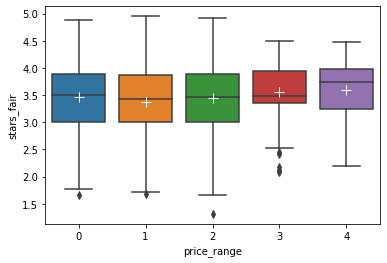

In [125]:
sns.boxplot(data=df, x='price_range', y='stars_fair', showmeans=True, meanprops={"marker":"+","markerfacecolor":"white", 
                                                                                 "markeredgecolor":"white", "markersize":"10"})

## Categories Analysed

In [48]:
df_categories = pd.DataFrame()

for cat in categories:
    temp = pd.pivot_table(df, index=cat, values=['stars', 'stars_fair', 'review_count', 'price_range']).join(
                          df[cat].value_counts().rename('counts'))
    temp.index.rename("Category", inplace=True)
    temp.rename(index={False: "0", True: cat}, inplace=True)
    temp.drop(index="0", inplace=True)
    df_categories = df_categories.append(temp)
    
df_categories.head()

,price_range,review_count,stars,stars_fair,counts
Category,,,,,
Japanese,1.649587,86.933884,3.485950,3.430462,605
Sandwiches,1.317016,51.743590,3.533800,3.461724,429
Nightlife,1.865125,113.788054,3.539499,3.471506,519
Bars,1.762590,95.632066,3.539568,3.467603,973
Coffee & Tea,1.332849,58.540698,3.666424,3.553403,688


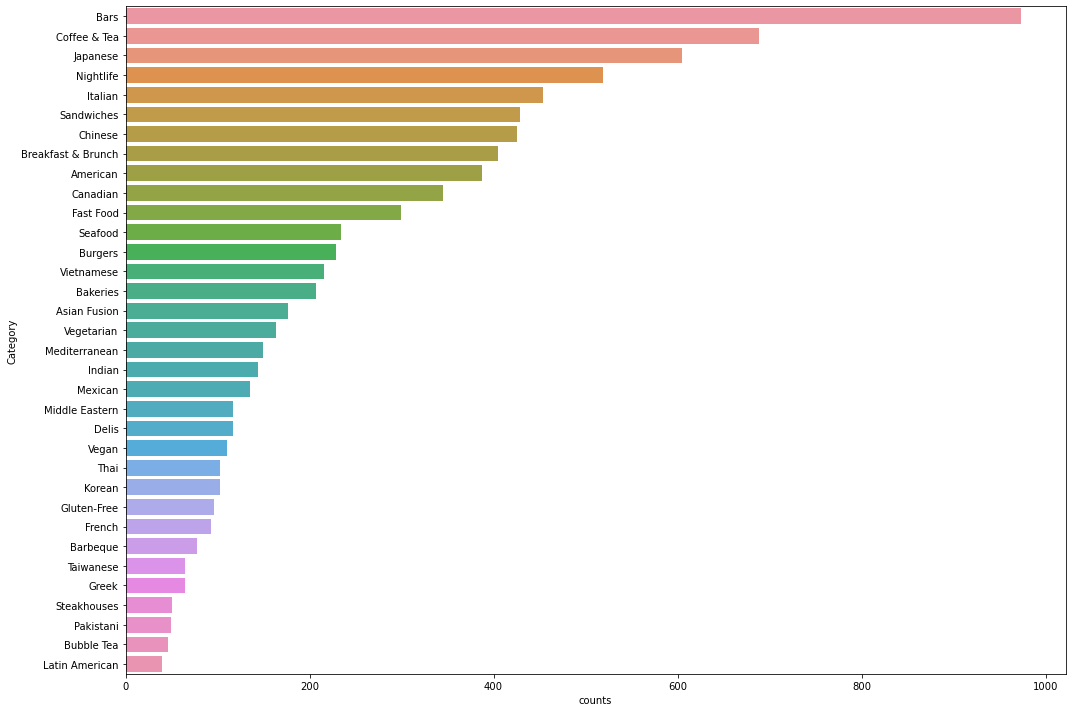

In [49]:
f = plt.figure(figsize=(15,10))
df_categories.sort_values("counts", ascending=False, inplace=True)
sns.barplot(data=df_categories, x="counts", y=df_categories.index)
f.tight_layout()

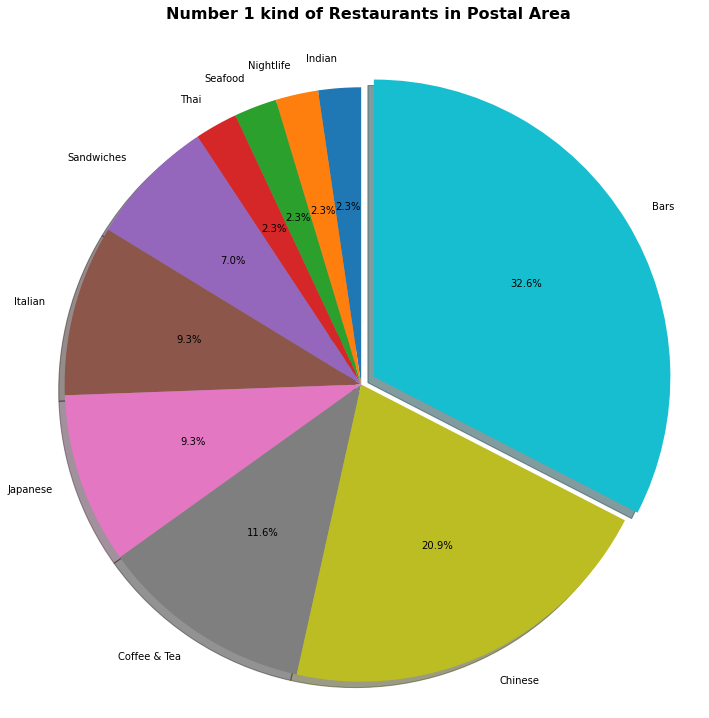

In [105]:
cat_postal_df = df.groupby(by="broad_postal_code").sum()
cat_postal_df.drop(["B6J", "nan"], inplace=True)

most_res_df = pd.DataFrame(cat_postal_df[categories].idxmax(axis=1)).rename(columns={0:"most_restaurants"}).reset_index()

sum_df = most_res_df.groupby(by="most_restaurants").count().sort_values("broad_postal_code") #.index.to_list() #["broad_postal_code"].to_list()
labels = sum_df.index.to_list()
sizes = sum_df["broad_postal_code"].to_list()

fig, ax = plt.subplots(figsize=(10,10))
ax.pie(sizes, explode=(0, 0, 0, 0, 0, 0, 0, 0, 0, 0.05), labels=labels, shadow=True, startangle=90, autopct='%1.1f%%')
ax.axis('equal')
ax.set_title("Number 1 kind of Restaurants by Postal Code", fontdict={'fontsize': 16,
        'fontweight': 'bold'}, y=1.05)
fig.tight_layout()
plt.show()

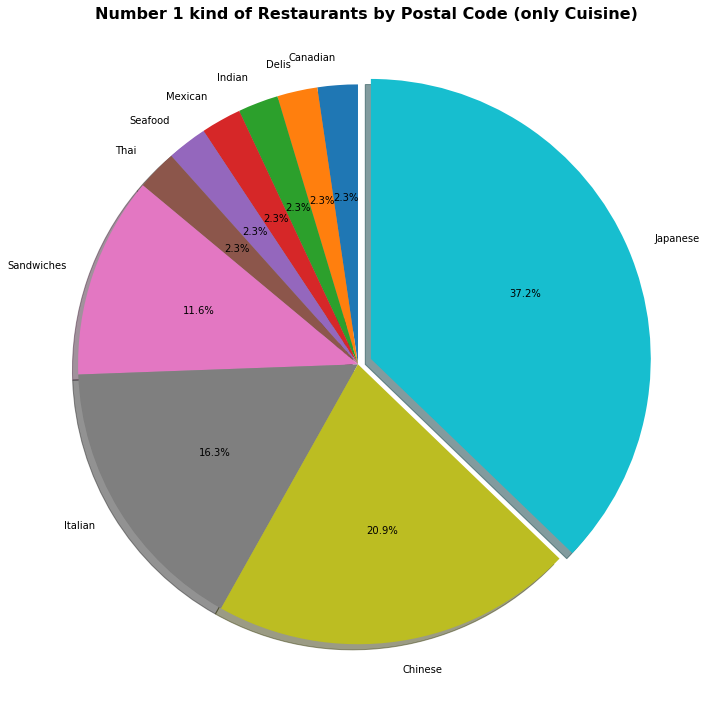

In [108]:
ignore = ["Bars", "Coffee & Tea", "Nightlife", "Breakfast & Brunch", "Fast Food", "Bakeries"]
cat_postal_df = df.drop(columns=ignore)
cat_postal_df = cat_postal_df.groupby(by="broad_postal_code").sum()
cat_postal_df.drop(["B6J", "nan"], inplace=True)

ignored = [item for item in categories if item not in ignore]

most_res_df = pd.DataFrame(cat_postal_df[ignored].idxmax(axis=1)).rename(columns={0:"most_restaurants"}).reset_index()

sum_df = most_res_df.groupby(by="most_restaurants").count().sort_values("broad_postal_code") #.index.to_list() #["broad_postal_code"].to_list()
labels = sum_df.index.to_list()
sizes = sum_df["broad_postal_code"].to_list()

fig, ax = plt.subplots(figsize=(10,10))
ax.pie(sizes, explode=(0, 0, 0, 0, 0, 0, 0, 0, 0, 0.05), labels=labels, shadow=True, startangle=90, autopct='%1.1f%%')
ax.axis('equal')
ax.set_title("Number 1 kind of Restaurants by Postal Code (only Cuisine)", fontdict={'fontsize': 16,
        'fontweight': 'bold'})
fig.tight_layout()
plt.show()

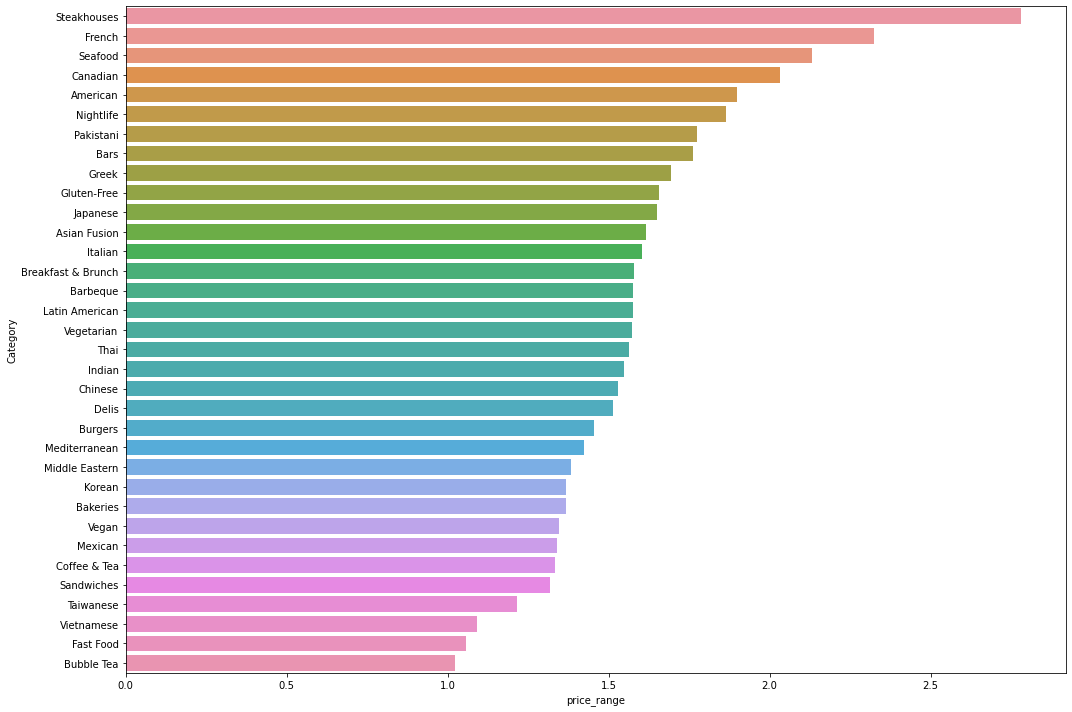

In [50]:
f = plt.figure(figsize=(15,10))
df_categories.sort_values("price_range", ascending=False, inplace=True)
sns.barplot(data=df_categories, x="price_range", y=df_categories.index)
f.tight_layout()

<AxesSubplot:xlabel='price_range', ylabel='stars_fair'>

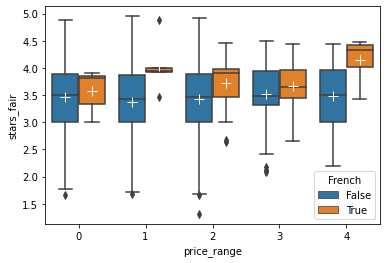

In [126]:
sns.boxplot(data=df, x='price_range', y='stars_fair', hue="French", showmeans=True, meanprops={"marker":"+","markerfacecolor":"white", 
                                                                                 "markeredgecolor":"white", "markersize":"10"})

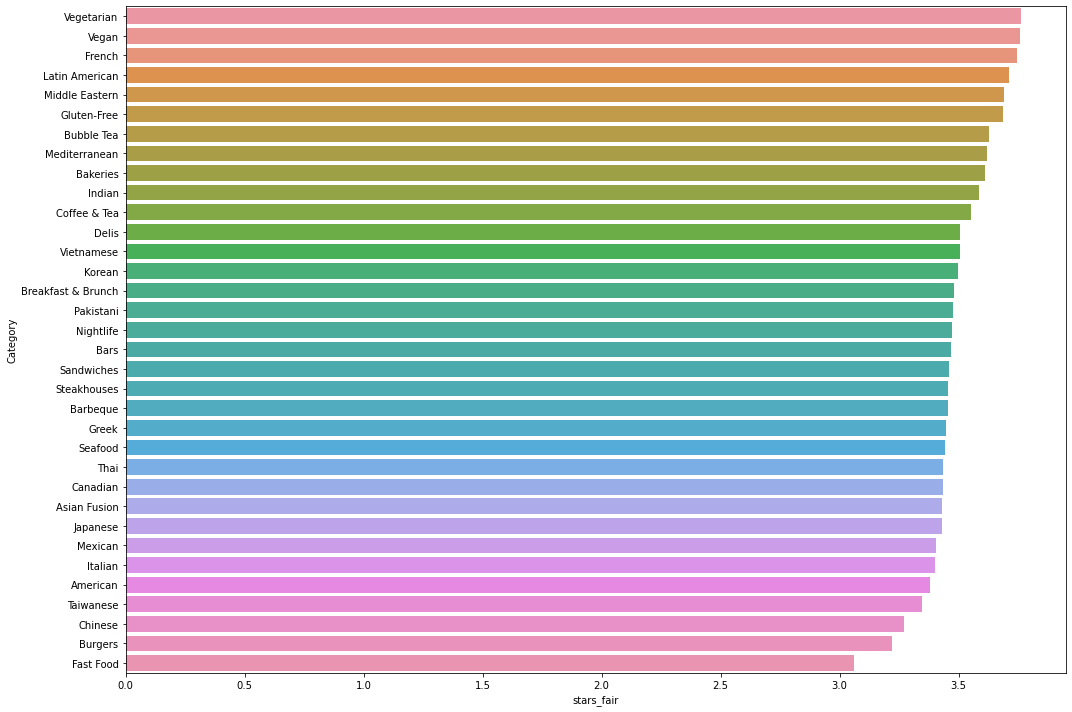

In [51]:
f = plt.figure(figsize=(15,10))
df_categories.sort_values("stars_fair", ascending=False, inplace=True)
sns.barplot(data=df_categories, x="stars_fair", y=df_categories.index)
f.tight_layout()

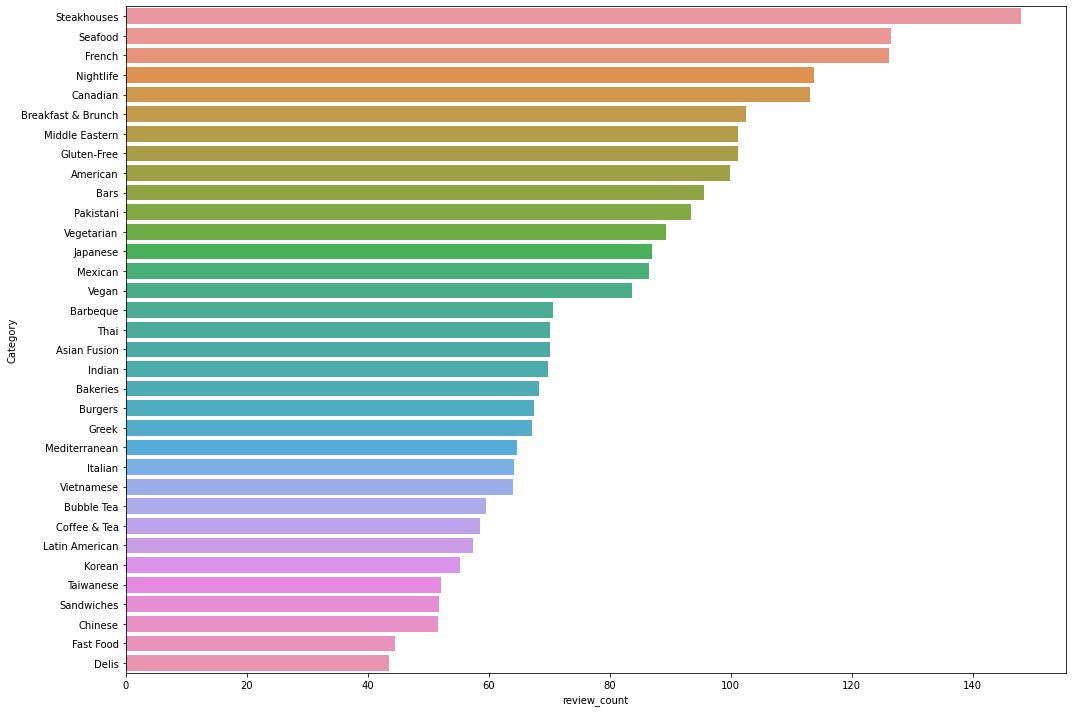

In [52]:
f = plt.figure(figsize=(15,10))
df_categories.sort_values("review_count", ascending=False, inplace=True)
sns.barplot(data=df_categories, x="review_count", y=df_categories.index)
f.tight_layout()